# Определение тональности текста с помощью фреймворка Flair

Определение тональности текста - задача классификации. Здесь мы будем обучать модель разделять комментарии на положительный и отрицательный, что является примером бинарной классификации.

Датасет для работы: [Отзывы о медучреждениях](https://github.com/blanchefort/datasets/tree/master/medical_comments).

Построение и тренировка модели будет осуществляться с помощью NLP-фреймворка [Flair](https://github.com/zalandoresearch/flair).

## 0. Загружаем необходимые пакеты

In [0]:
!pip install flair

In [0]:
# Подключаем диск Google Drive к Colab, на котором будем хранить данные
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from flair.data import Corpus
from flair.datasets import ClassificationCorpus
from flair.embeddings import BytePairEmbeddings
from flair.embeddings import DocumentPoolEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from flair.visual.training_curves import Plotter
from flair.data import Sentence

In [0]:
plt.figure(figsize=(12, 6), dpi=100)
plt.style.use('bmh')

<Figure size 1200x600 with 0 Axes>

## 1. Подготавливаем датасет для работы

In [0]:
df = pd.read_csv('/content/drive/My Drive/colab_data/sentiment/data/prodoctorov_raw.csv')

In [0]:
# Посмотрим на датасет
df.head()

,text,sentiment
0,Хочу написать про окулиста Светлану Хизировну...,Ужасно
1,Спасибо коллективу роддома за дочку и сыночка...,Хорошо
2,"Ужасные врачи. Если звонить ночью, то не дозв...",Ужасно
3,Очень приятные воспоминания остались после ро...,Плохо
4,Спасибо огромное всему персоналу за их отзывч...,Отлично


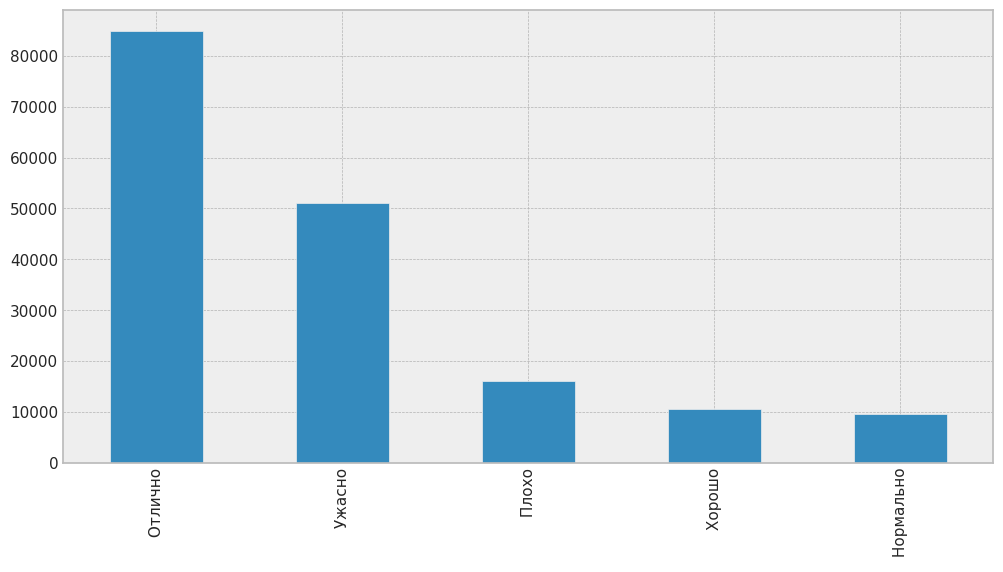

In [0]:
# Посмотрим на распределение датасета по нашей целевой переменной
df.sentiment.value_counts().plot.bar()

Как видно, из графика, в датасете присутствует сильных дисбаланс. Но для решения нашей задачи (бинарной классификации) нам нужны лишь две категории текстов: положительные, отрицательные. Поэтому преобразуем датасет следующим образом:

* **Положительные (1)** = «Отлично»
* **Отрицательные (0)** = «Ужасно» + «Плохо»

А комментарии типа «Хорошо» и «Нормально» удалим.

In [30]:
# отметим, что в датасете название категории начинается с пробела
df.sentiment.unique()

array([' Ужасно', ' Хорошо', ' Плохо', ' Отлично', ' Нормально'],
      dtype=object)

In [0]:
df = df.drop(df[df.sentiment == ' Хорошо'].index)

In [0]:
df = df.drop(df[df.sentiment == ' Нормально'].index)

In [0]:
df.sentiment.unique()

array([' Ужасно', ' Плохо', ' Отлично'], dtype=object)

In [0]:
sent_map = {
    ' Ужасно' : 0,
    ' Плохо' : 0,
    ' Отлично' : 1
}

df.sentiment = df.sentiment.map(sent_map)

Теперь посмотрим на распределение преобразованного датасета.

Хоть получившееся распределение и не идеально (текстов категории 1 немного больше, чем текстов категории 2), мы всё же оставим это распределение таким, ничего больше не сокращая и не добавляя.

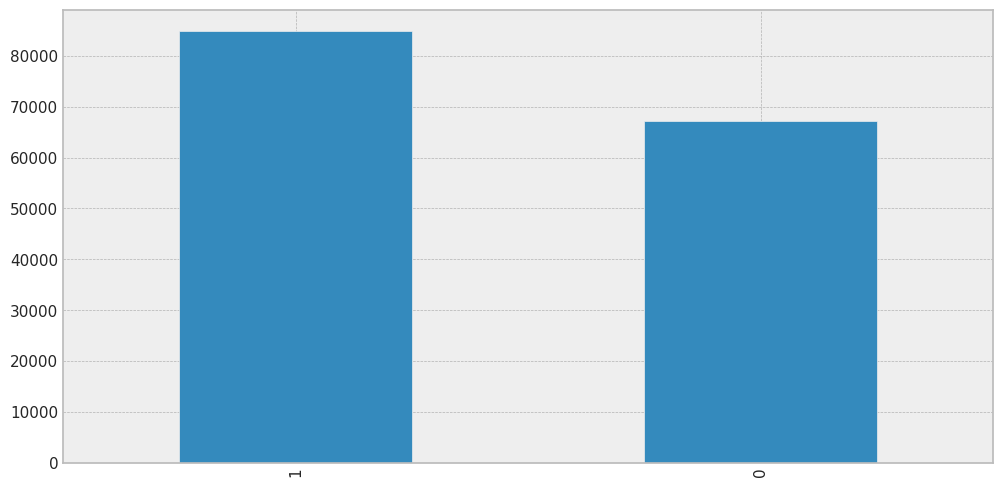

In [0]:
df.sentiment.value_counts().plot.bar()

Произведём предобработку наших текстов:
* приведение к нижнему регистру;
* замена буквы «ё» на букву «е»;
* удаление всех символов, кроме букв русского и английского языка;
* удаление лишних пробелов.

Лемматизацию (приведение слова к нормальной форме: *кошками → кошка*) мы производить не будем, чтобы иметь возможность учитывать оттенки слов.

Предобработанные данные сохраним в формате [fastText](https://fasttext.cc/). Это текстовый файл, в котором сохранены предобработанные тексты с меткой класса.

Первым параметром идёт метка, начинающаяся со служебного слова `__label__`.

Например, так: `__label__mark` или так: `__label__0`.

Затем через пробел идёт сам предобработанный текст. Каждый элемент датасета начинается с новой строки.

Для этого преобразуем признак `sentiment`. И поменяем колонки местами.

In [0]:
df.text = df.text.str.lower()
df.text = df.text.str.replace('ё', 'е', regex=False)
df.text = df.text.str.replace('[^a-zа-я]+', ' ')
df.text = df.text.str.replace(' +', ' ')
df.text = df.text.str.strip()

In [0]:
df = df.reindex(columns=['sentiment', 'text'])

In [0]:
df.sentiment = '__label__' + df.sentiment.apply(str)
df.head()

,sentiment,text
0,__label__0,хочу написать про окулиста светлану хизировну ...
2,__label__0,ужасные врачи если звонить ночью то не дозвони...
3,__label__0,очень приятные воспоминания остались после род...
4,__label__1,спасибо огромное всему персоналу за их отзывчи...
5,__label__1,врачи очень отзывчивые о о очень хорошие они с...


Разбиваем предобработанный датасет на три выборки:

* обучающую
* валидационную
* тестовую



In [0]:
# https://stackoverflow.com/a/38251063
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.loc[perm[:train_end]]
    validate = df.loc[perm[train_end:validate_end]]
    test = df.loc[perm[validate_end:]]
    return train, validate, test

In [0]:
train, validate, test = train_validate_test_split(df, train_percent=.7, validate_percent=.2, seed=700)

In [0]:
train.shape[0], validate.shape[0], test.shape[0]

(106418, 30405, 15203)

In [0]:
train.to_csv('/content/drive/My Drive/colab_data/sentiment/data/sentiment.train.fasttext',
             sep=' ',
             index=False,
             header=None)
validate.to_csv('/content/drive/My Drive/colab_data/sentiment/data/sentiment.validate.fasttext',
                sep=' ',
                index=False,
                header=None)
test.to_csv('/content/drive/My Drive/colab_data/sentiment/data/sentiment.test.fasttext',
            sep=' ',
            index=False,
            header=None)

## 2. Создание и обучение модели

Загружаем подготовленный датасет. Для более быстрой обработки информации можно весть датасет поместить в оперативную память. Для этого выставляем флаг: 

```
in_memory=True
```

Здесь я не загружаю весь датасет в память, так как Google Colab ограничивает мне оперативню память тринадцатью гигабайтами.



In [0]:
data_folder = '/content/drive/My Drive/colab_data/sentiment/data/'

corpus: Corpus = ClassificationCorpus(
    data_folder,
    train_file='sentiment.train.fasttext',
    dev_file='sentiment.validate.fasttext',
    test_file='sentiment.test.fasttext',
    in_memory=False)

2019-08-27 07:49:49,836 Reading data from /content/drive/My Drive/colab_data/sentiment/data
2019-08-27 07:49:49,838 Train: /content/drive/My Drive/colab_data/sentiment/data/sentiment.train.fasttext
2019-08-27 07:49:49,842 Dev: /content/drive/My Drive/colab_data/sentiment/data/sentiment.validate.fasttext
2019-08-27 07:49:49,844 Test: /content/drive/My Drive/colab_data/sentiment/data/sentiment.test.fasttext


In [0]:
# Проверим загруженные данные
print(len(corpus.train), len(corpus.dev), len(corpus.test), sep=', ')

106418, 30405, 15203


In [0]:
# Наши метки
# 0 - негативные отзывы, 1 - положительные
label_dict = corpus.make_label_dictionary()

2019-08-27 07:50:01,863 Computing label dictionary. Progress:


100%|██████████| 106418/106418 [04:07<00:00, 430.79it/s]

2019-08-27 07:54:09,045 [b'1', b'0']


В качестве векторов слов мы будем использовать BPE — [Byte Pair Embeddings](https://nlp.h-its.org/bpemb/). Для нашей задачи — анализ тональности текста — данная модель, пожалуй, одно из наилучших решений на сегодняшний день.

Во-первых, если мы будем использовать свой словарь — словарь, основанный на словах из нашего датасета, то всегда есть возможность, что в процессе использования модели ей встретится незнакомое слово.

Во-вторых, уже существующие полнословные словари слишком большие.

В-третьих, с помощью модели BPE мы будем учитывать возможные опечатки в тексте и жаргонную лексику, а это очень распространённое явление в пользовательских комментариях в соцсетях. Такая модель, как, например, FastText тоже умеет учитывать не встречающиеся в её словаре слова, но она слишком большая — всё это (в частности для русского языка) из-за того, что слова в словаре были некачественно предобработаны.

Таким образом, BPE — предобученная модель сравнительно небольшого размера, с помошью которой можно учесть опечатки, жаргон и даже несуществующие в словаре слова.

Есть несколько вариаций BPE. В зависимости от словаря используются различные методы разбиения слова на подслова (как слоги). Благодаря разбиению на подслова мы имеем возможность учитывать различные формы слов.

Примеры различных эмбеддингов  BPE для русского языка (для текста «кошачья мята»):

| Размер словаря  |	Сегментация                                   |
|:---------------:|:----------------------------------------------|
|1000             |`['▁ко', 'ша', 'ч', 'ь', 'я', '▁м', 'я', 'та']`|
|3000             |`['▁ко', 'ша', 'ч', 'ья', '▁мя', 'та']`	      |
|5000	            |`['▁ко', 'ша', 'ч', 'ья', '▁мя', 'та']`        |
|10000	          |`['▁ко', 'ша', 'ч', 'ья', '▁мя', 'та']`        |
|25000	          |`['▁ко', 'ша', 'чья', '▁мя', 'та']`            |
|50000	          |`['▁коша', 'чья', '▁мя', 'та']`                |
|100000	          |`['▁коша', 'чья', '▁мя', 'та']`                |
|200000	          |`['▁кошачья', '▁мята']`                        |

Указать необходимый размер словаря для BPE во Flair можно с помощью аргумента `syllables`:


```
BytePairEmbeddings(language='ru', dim=50, syllables=1000)
```

In [0]:
bpe = BytePairEmbeddings(language='ru', dim=100, syllables=50000)

downloading https://nlp.h-its.org/bpemb/ru/ru.wiki.bpe.vs50000.model


100%|██████████| 1404906/1404906 [00:00<00:00, 1987685.46B/s]


downloading https://nlp.h-its.org/bpemb/ru/ru.wiki.bpe.vs50000.d100.w2v.bin.tar.gz


100%|██████████| 19076003/19076003 [00:01<00:00, 11751851.80B/s]
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Каждое предложение имеет разный размер, поэтому преобразованные векторы тоже будут разноразмерными. Однако, мы не можем передавать классификатору разноразмерные параметры. Для этого нужно привести наши данные к единой размерности. 

Для этого воспользуемся классом `DocumentPoolEmbeddings` фреймворка Flair. Он принимает различные вектора слов текста и приводит их к тензору единой размерности - эмбеддингу документа.

In [0]:
document_emb = DocumentPoolEmbeddings([bpe], fine_tune_mode='nonlinear')

In [0]:
# Инициализируем текстовый классификатор
classifier = TextClassifier(document_emb, label_dictionary=label_dict)

# По умолчанию в качестве оптимизатора используется SGD.
# Мы будем использовать его, поэтому не указываем явно тип оптимизатора:
trainer = ModelTrainer(classifier, corpus)

# Если же нужно использовать какой-то иной алгоритм, его нужно указать:
#
# from torch.optim.adam import Adam
# trainer = ModelTrainer(classifier, corpus, optimizer=Adam)

# По умолчанию данный фреймворк использует GPU. Если GPU нет, фреймворк сам 
# выбирает CPU.
# Если для обучения используется CPU, можно указать количество процессоров
# trainer.num_workers = 15
#
# Что используется на данный момент, можно узнать, выполнив следующий код:
# import flair
# print(flair.device)

In [8]:
# Начинаем тренировку
# Можно указывать сколько угодно много эпох, а потом, когда модель будет 
# достаточно обучена, остановить выполнение кода. Фреймворк поймёт, что
# надо прекратить обучение,- остановится, пересчитает все веса
# и сохранит наилучший результат в файл best_model.pt
trainer.train(
    '/content/drive/My Drive/colab_data/sentiment/model',
    learning_rate=0.1,
    mini_batch_size=64,
    anneal_factor=0.5,
    patience=5,
    max_epochs=2000,
    monitor_train=True)

2019-08-27 07:57:04,662 ----------------------------------------------------------------------------------------------------
2019-08-27 07:57:04,666 Model: "TextClassifier(
  (document_embeddings): DocumentPoolEmbeddings(
    fine_tune_mode=nonlinear, pooling=mean
    (embeddings): StackedEmbeddings(
      (list_embedding_0): BytePairEmbeddings(model=bpe-ru-50000-100)
    )
    (embedding_flex): Linear(in_features=200, out_features=200, bias=False)
    (embedding_flex_nonlinear): ReLU(inplace)
    (embedding_flex_nonlinear_map): Linear(in_features=200, out_features=200, bias=True)
  )
  (decoder): Linear(in_features=200, out_features=2, bias=True)
  (loss_function): CrossEntropyLoss()
)"
2019-08-27 07:57:04,670 ----------------------------------------------------------------------------------------------------
2019-08-27 07:57:04,672 Corpus: "Corpus: 106418 train + 30405 dev + 15203 test sentences"
2019-08-27 07:57:04,674 ----------------------------------------------------------------

{'test_score': 0.9127,
 'dev_score_history': [0.9104],
 'train_loss_history': [tensor(0.2255, device='cuda:0')],
 'dev_loss_history': [tensor(0.2275, device='cuda:0')]}

## 3. Использование обученной модели

Как видно из листинга выше, уже после первой эпохи мы достигли довольно-таки неплохих результатов обучения, поэтому я остановил процесс. Для моделей, которые предстоит использовать в проде, конечно же, не нужно останавливать процесс обучения, пока ещё есть возможность улучшить качество модели.

Итак, параметры получившейся модели таковы:

* **Accuracy:** 83,94%
* **F1:** 91,27%

In [14]:
# Загружаем модель для использования
model = TextClassifier.load('/content/drive/My Drive/colab_data/sentiment/model/best-model.pt')

2019-08-27 09:24:50,116 loading file /content/drive/My Drive/colab_data/sentiment/model/best-model.pt


In [16]:
# Сколько параметров у нашей модели?
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'В ходе тренировки модели было использовано {count_parameters(model):,} параметров.')

В ходе тренировки модели было использовано 80,602 параметров.


In [0]:
# Предобработка единичного комментария
# Те же самые операции, что мы производили над датасетом,
# только теперь для единичного комментария.
def preprocess_text(text):
  text = text.replace('\n', ' ')
  text = text.replace('ё', 'е')
  text = re.sub('[^a-zA-Zа-яА-Я]+', ' ', text).lower()
  return text.strip()

In [0]:
# Посмотрим, как модель определяет положительный комментарий
t_1 = """Несколько дней назад в лаборатории сдавала анализ крови.Претензий к 
качеству выполнения и отношению со стороны сотрудников абсолютно нет. 
Сама процедура заняла у меня буквально 10 минут, а результат я получила на 
почту буквально через день. Внутри все оборудовано для людей, удобные 
диваны, кулер с водой и стаканчики, журналы. В целом есть все необходимое. 
Персонал вежливый и внимательный. Инвитро стал для меня ещё одним 
доказательством, что лучше заплатить немного больше, но получить качественный 
сервис, и самое главное - правильные результаты анализов."""

In [23]:
sentence = Sentence(preprocess_text(t_1))
model.predict(sentence)

print(sentence.labels)

[1 (0.9709076285362244)]


In [0]:
# Посмотрим, сможет ли модель определить отрицательный комментарий
t_0 = """Ужасные очереди. Терапевт принимает по 40-50 минут одного человека. 
Ни разу ещё так долго не проходила медосмотр. Очереди везде - в регистратуре, 
в каждый кабинет и обслуживание максимально долгое. Даже по записи люди сидели 
и ждали уже после своего времени, чтобы пройти врача. Не говоря уже о живой 
очереди! И тут ещё деньги за это берут!"""

In [27]:
sentence = Sentence(preprocess_text(t_0))
model.predict(sentence)

print(sentence.labels)

[0 (0.8297977447509766)]


Как видим, модель великолепно справилась с задачей, и распознала как положительный, так и отрицательный комментарий.

Ответ модели:

```
[1 (0.9709076285362244)]
[0 (0.8297977447509766)]
```

Первым параметром идёт категория текста, определённая моделью.

Вторым параметром — вероятность определения категории.

